In [ ]:
import torch
import numpy as np
import pandas as pd
import re
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import statsmodels
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from pydub import AudioSegment
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from util import load_to_array, transcribe_batch, TrialData, WordBoundary
import pickle

In [ ]:
# Setup Model and Processor
model_id = "openai/whisper-small"
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

In [18]:
with open('data/selAd_trial_data.pkl', 'rb') as file:
    raw_data = pickle.load(file)

In [ ]:

def get_audio_for_trial(context_np, target_np, sample_rate=16000):
    """
    Reconstructs the 30s input buffer for Whisper from saved arrays.
    Crucially, it aligns the target word onset to exactly 28.0 seconds.
    """
    # 28 seconds * 16000 samples/sec = 448,000 samples
    TARGET_ONSET_IDX = 448000
    TOTAL_SAMPLES = 480000 # 30 seconds
    
    # Initialize empty canvas (digital silence)
    audio_buffer = np.zeros(TOTAL_SAMPLES, dtype=np.float32)
    ctx_len = len(context_np)
    ctx_start = TARGET_ONSET_IDX - ctx_len
    
    # Safety check
    if ctx_start < 0:
        # If context is longer than 28s, trim the start
        context_np = context_np[-TARGET_ONSET_IDX:]
        ctx_start = 0
        
    audio_buffer[ctx_start:TARGET_ONSET_IDX] = context_np
    
    # Place Target (starting exactly at 28s)
    tgt_len = len(target_np)
    # Ensure we don't overrun the 30s buffer
    if TARGET_ONSET_IDX + tgt_len > TOTAL_SAMPLES:
        target_np = target_np[:TOTAL_SAMPLES - TARGET_ONSET_IDX]
        
    audio_buffer[TARGET_ONSET_IDX : TARGET_ONSET_IDX + len(target_np)] = target_np
    
    return audio_buffer

In [20]:
meta_rows = []
for idx, item in enumerate(raw_data):
    m = item['metadata']
    final = m.transcript.split()[-1][0].lower()
    outcome = 'voiced' if final=='b' else 'voiceless' if final=='p' else 'neither'
    pair_name = item.get('target_pair', 'unknown_pair') 
    
    meta_rows.append({
        'original_index': idx,
        'talker': 'hope',
        'condition': m.condition,
        'target_word': m.target_word, # Keep specific word for reference
        'step': m.continuum_step,
        'transcript': m.transcript,
        'outcome': outcome,
        'trial_id': f"{pair_name}_{item['iteration']}" 
        
    })

df = pd.DataFrame(meta_rows)
df.to_csv('data/SelAd_whisper_eval.csv', index = False)


<Figure size 1000x600 with 0 Axes>

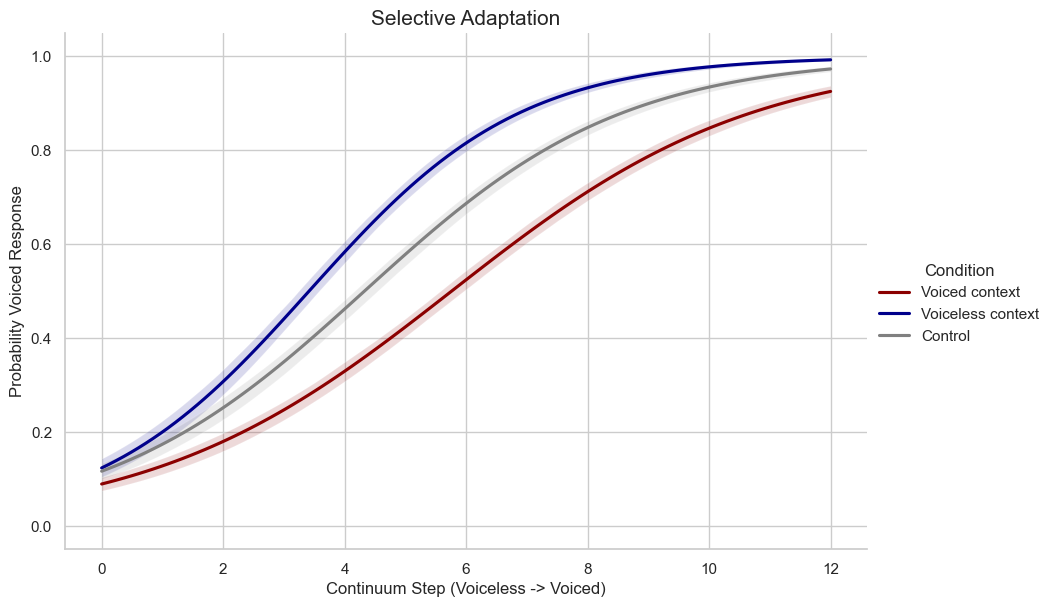

In [ ]:
df_plot = df[df['outcome'] != 'neither'].copy()
df_plot['is_voiced'] = (df_plot['outcome'] == 'voiced').astype(int)
df_plot['Condition'] = np.where(
    df_plot['condition']=='voiceless', 'Voiceless context', np.where(
        df_plot['condition']=='voiced', 'Voiced context', 'Control'
    )
)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

g = sns.lmplot(
    data=df_plot, 
    x='step', 
    y='is_voiced', 
    hue='Condition', 
    logistic=True, 
    scatter=False,
    n_boot=500,
    ci=95,
    height=6, 
    aspect=1.5,
    palette={'Voiced context': 'darkred', 'Voiceless context': 'darkblue', 'Control': 'gray'},
)

g.set_axis_labels("Continuum Step (Voiceless -> Voiced)", "Probability Voiced Response")
plt.title("Selective Adaptation", fontsize=15)
plt.ylim(-0.05, 1.05)
plt.show()

In [ ]:
pivot_df = df.pivot_table(
    index=['step', 'trial_id'], 
    columns='condition', 
    values=['outcome', 'original_index'],
    aggfunc='first'
).reset_index()

pivot_df = pivot_df.sort_values('trial_id')
pivot_df.columns = [f"{c[0]}_{c[1]}" if c[1] else c[0] for c in pivot_df.columns]

# Filter for the flip trials
critical_trials = pivot_df[
    (pivot_df['outcome_voiced'] == 'voiceless') & 
    (pivot_df['outcome_voiceless'] == 'voiced')
]

Found 644 critical trials to analyze.


In [ ]:

def time_to_index(sec):
    return int(sec / 0.02)

def get_all_encoder_layers(audio_array):
    """
    Takes a 16kHz numpy array, runs it through the Whisper encoder,
    and returns all hidden states for all layers.
    """
    # Pre-process the audio to log-mel spectrogram
    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt").to(device)
    input_features = inputs.input_features
    
    # Run through encoder with 'output_hidden_states' enabled
    with torch.no_grad():
        encoder = model.get_encoder()
        outputs = encoder(
            input_features, 
            output_hidden_states=True, 
            return_dict=True
        )
    
    # Stack layers into a single tensor [13, 1, 1500, 768]
    return torch.stack(outputs.hidden_states)

In [ ]:

def extract_all_layers(trials, output_path):
    """
    Iterates through trials and extracts mean-pooled hidden states for 
    all 13 layers across all conditions.
    """
    hidden_states = []

    for _, row in tqdm.tqdm(trials.iterrows()):
        # Retrieve the indices for the three conditions
        idx_voiced = int(row['original_index_voiced'])
        idx_voiceless = int(row['original_index_voiceless'])
        idx_control = int(row['original_index_control']) 
        
        indices = {'voiced': idx_voiced, 'voiceless': idx_voiceless, 'control': idx_control}
        
        # Process each condition
        for cond_name, list_idx in indices.items():
            data_packet = raw_data[list_idx]
            
            # Reconstruct audio
            audio = get_audio_for_trial(
                data_packet['context'], 
                data_packet['metadata'].target_array
            )
            
            # Get Hidden States
            # The target word ALWAYS starts at 28.0s
            # 28.0s = 28.0 / 0.02 = 1400 frames
            start_frame = 1400 
            end_frame = 1400 + 2 
            
            # Pass to model
            layers_tensor = get_all_encoder_layers(audio) 
            
            # Slice and Mean Pool
            # layers_tensor shape: [13, 1, 1500, 768]
            token_vectors = layers_tensor[:, :, start_frame:end_frame, :]
            pooled_vectors = token_vectors.mean(dim=2).squeeze(1).cpu().numpy()

            trial_record = {
                'trial_id': row['trial_id'],
                'condition': cond_name,
                'step': row['step'],
                'transcript': row[f'outcome_{cond_name}'],
            }
            for l in range(13):
                trial_record[f'layer_{l}'] = pooled_vectors[l]
                
            hidden_states.append(trial_record)

    df_results = pd.DataFrame(hidden_states)
    df_results.to_pickle(output_path)
    return df_results

hidden_states = extract_all_layers(critical_trials, 'data/hidden_states.pkl')
all_hidden_states = extract_all_layers(pivot_df, 'data/all_hidden_states.pkl')
    

3900it [22:00,  2.95it/s]


In [ ]:
with open('data/critical_hidden_states.pkl', 'rb') as file:
    hidden_states = pickle.load(file)

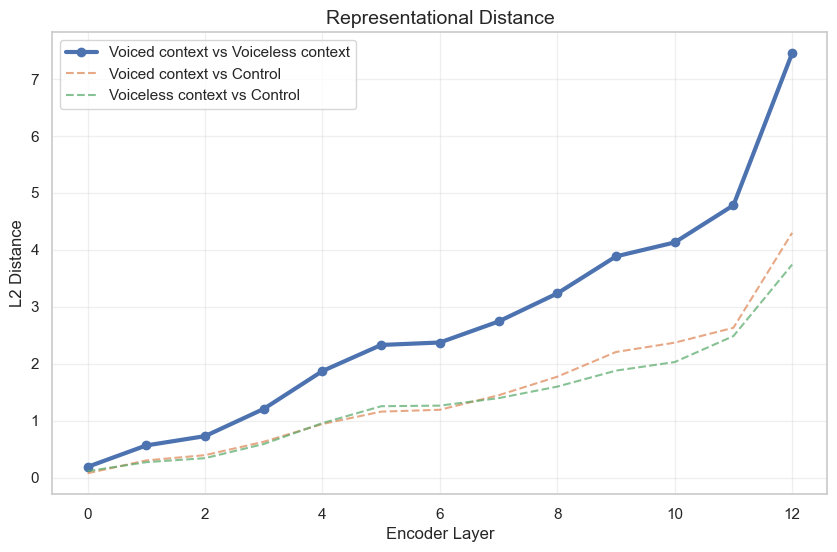

In [30]:
# Calculate distances for all three relationships
dist_v_vl = []  # Voiced vs Voiceless
dist_v_ctrl = [] # Voiced vs Control
dist_vl_ctrl = [] # Voiceless vs Control

for i in range(13):
    v_mean = np.stack(hidden_states[hidden_states['condition']=='voiced'][f'layer_{i}']).mean(axis=0)
    vl_mean = np.stack(hidden_states[hidden_states['condition']=='voiceless'][f'layer_{i}']).mean(axis=0)
    ctrl_mean = np.stack(hidden_states[hidden_states['condition']=='control'][f'layer_{i}']).mean(axis=0)
    
    dist_v_vl.append(np.linalg.norm(v_mean - vl_mean))
    dist_v_ctrl.append(np.linalg.norm(v_mean - ctrl_mean))
    dist_vl_ctrl.append(np.linalg.norm(vl_mean - ctrl_mean))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dist_v_vl, label="Voiced context vs Voiceless context", marker='o', linewidth=3)
plt.plot(dist_v_ctrl, label="Voiced context vs Control", linestyle='--', alpha=0.7)
plt.plot(dist_vl_ctrl, label="Voiceless context vs Control", linestyle='--', alpha=0.7)

plt.title("Representational Distance", fontsize=14)
plt.xlabel("Encoder Layer", fontsize=12)
plt.ylabel("L2 Distance", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

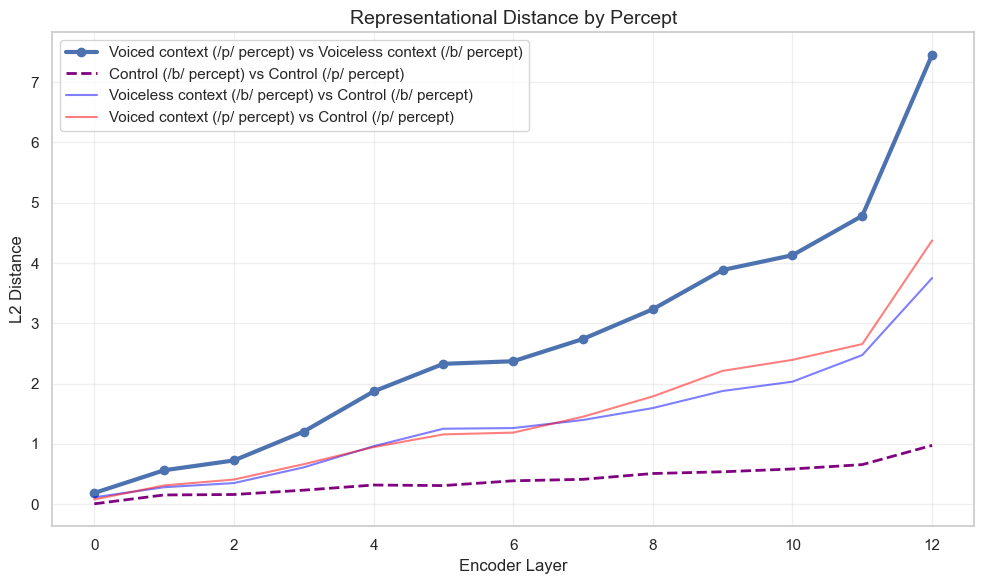

In [56]:
# Initialize distance lists
dist_v_vl = []
dist_ctrlV_ctrlVL = [] # Distance between the two internal "decisions" for Control
dist_v_ctrlVL = []     # voiced vs Control-voiceless
dist_vl_ctrlV = []   # Pure voiceless vs Control-voiceless

for i in range(13):
    layer_col = f'layer_{i}'
    
    # 1. Define the four groups
    v_states = np.stack(hidden_states[hidden_states['condition']=='voiced'][layer_col])
    vl_states = np.stack(hidden_states[hidden_states['condition']=='voiceless'][layer_col])
    
    # Control subsetting based on outcome (transcript)
    ctrl_v_states = np.stack(hidden_states[(hidden_states['condition']=='control') & 
                                           (hidden_states['transcript']=='voiced')][layer_col])
    ctrl_vl_states = np.stack(hidden_states[(hidden_states['condition']=='control') & 
                                            (hidden_states['transcript']=='voiceless')][layer_col])
    
    # 2. Calculate Means
    v_mean = v_states.mean(axis=0)
    vl_mean = vl_states.mean(axis=0)
    cv_mean = ctrl_v_states.mean(axis=0)
    cvl_mean = ctrl_vl_states.mean(axis=0)
    
    # 3. Calculate Distances
    dist_v_vl.append(np.linalg.norm(v_mean - vl_mean))
    dist_ctrlV_ctrlVL.append(np.linalg.norm(cv_mean - cvl_mean))
    dist_v_ctrlVL.append(np.linalg.norm(v_mean - cvl_mean))
    dist_vl_ctrlV.append(np.linalg.norm(vl_mean - cv_mean))

plt.figure(figsize=(10, 6))

# Main Divergence
plt.plot(dist_v_vl, label="Voiced context (/p/ percept) vs Voiceless context (/b/ percept)", marker='o', linewidth=3)

# The "Internal Decision" Divergence in Control
plt.plot(dist_ctrlV_ctrlVL, label="Control (/b/ percept) vs Control (/p/ percept)", color='purple', linestyle='--', linewidth=2)

# How close the control trials are to their "decided" categories
plt.plot(dist_vl_ctrlV, label="Voiceless context (/b/ percept) vs Control (/b/ percept)", color='blue', alpha=0.5)
plt.plot(dist_v_ctrlVL, label="Voiced context (/p/ percept) vs Control (/p/ percept)", color='red', alpha=0.5)

plt.title("Representational Distance by Percept", fontsize=14)
plt.xlabel("Encoder Layer", fontsize=12)
plt.ylabel("L2 Distance", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

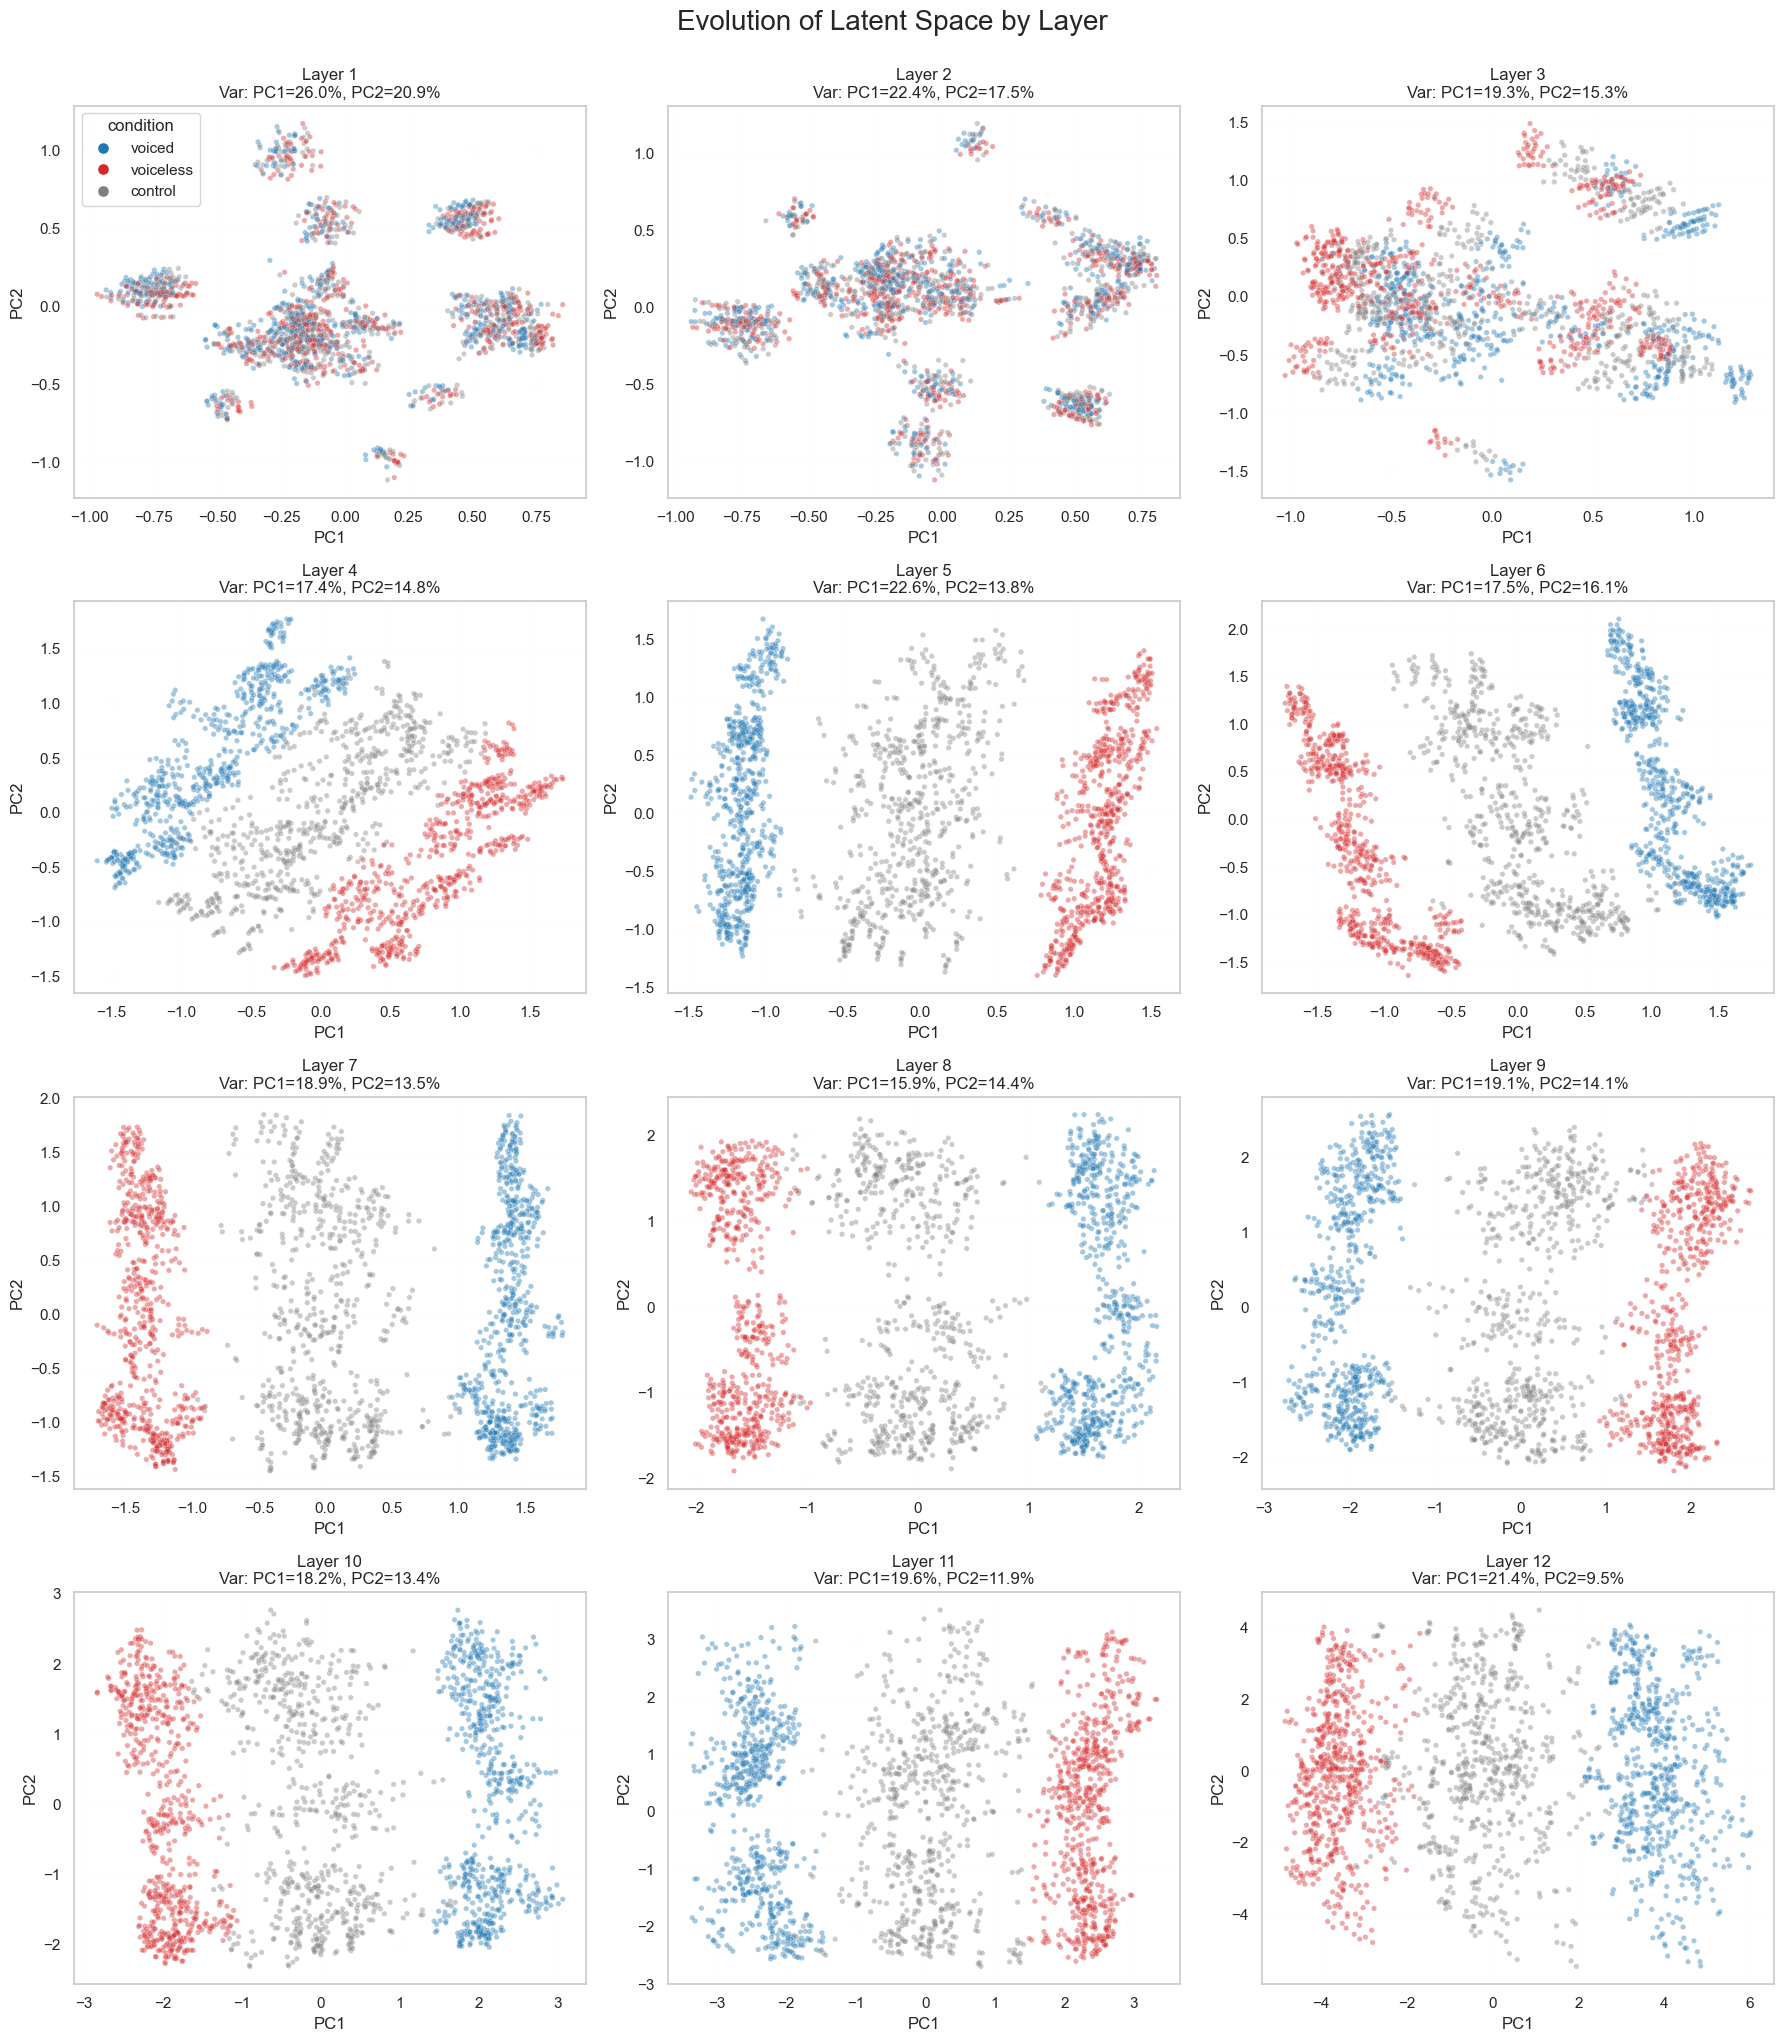

In [45]:

def plot_layer_pca_grid(df):
    # Setup the figure grid (5 rows, 3 columns for 13 layers)
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()
    
    # Define colors for conditions
    palette = {'voiced': '#1f77b4', 'voiceless': '#d62728', 'control': '#7f7f7f'}
    
    for i in range(1,13):
        ax = axes[i-1]
        layer_col = f'layer_{i}'
        
        # 1. Prepare data for this layer
        # Stack the arrays into a (N, 768) matrix
        X = np.stack(df[layer_col].values)
        
        # 2. Run PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        # 3. Plot using Seaborn for easy coloring
        sns.scatterplot(
            x=X_pca[:, 0], 
            y=X_pca[:, 1], 
            hue=df['condition'], 
            palette=palette,
            ax=ax,
            alpha=0.4,
            s=15,
            legend=(i == 1)
        )

        if i == 1:
            leg = ax.get_legend()
            if leg:
                for lh in leg.legend_handles: 
                    lh.set_alpha(1) 
                    if hasattr(lh, 'set_sizes'):
                        lh.set_sizes([50])
                    elif hasattr(lh, 'set_markersize'):
                        lh.set_markersize(8)
        
        # Calculate variance explained for titles
        var_exp = pca.explained_variance_ratio_
        ax.set_title(f"Layer {i}\nVar: PC1={var_exp[0]:.1%}, PC2={var_exp[1]:.1%}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.02)

    plt.tight_layout()
    plt.suptitle("Evolution of Latent Space by Layer", fontsize=20, y=1.02)
    plt.show()

# Run the visualization
plot_layer_pca_grid(hidden_states)

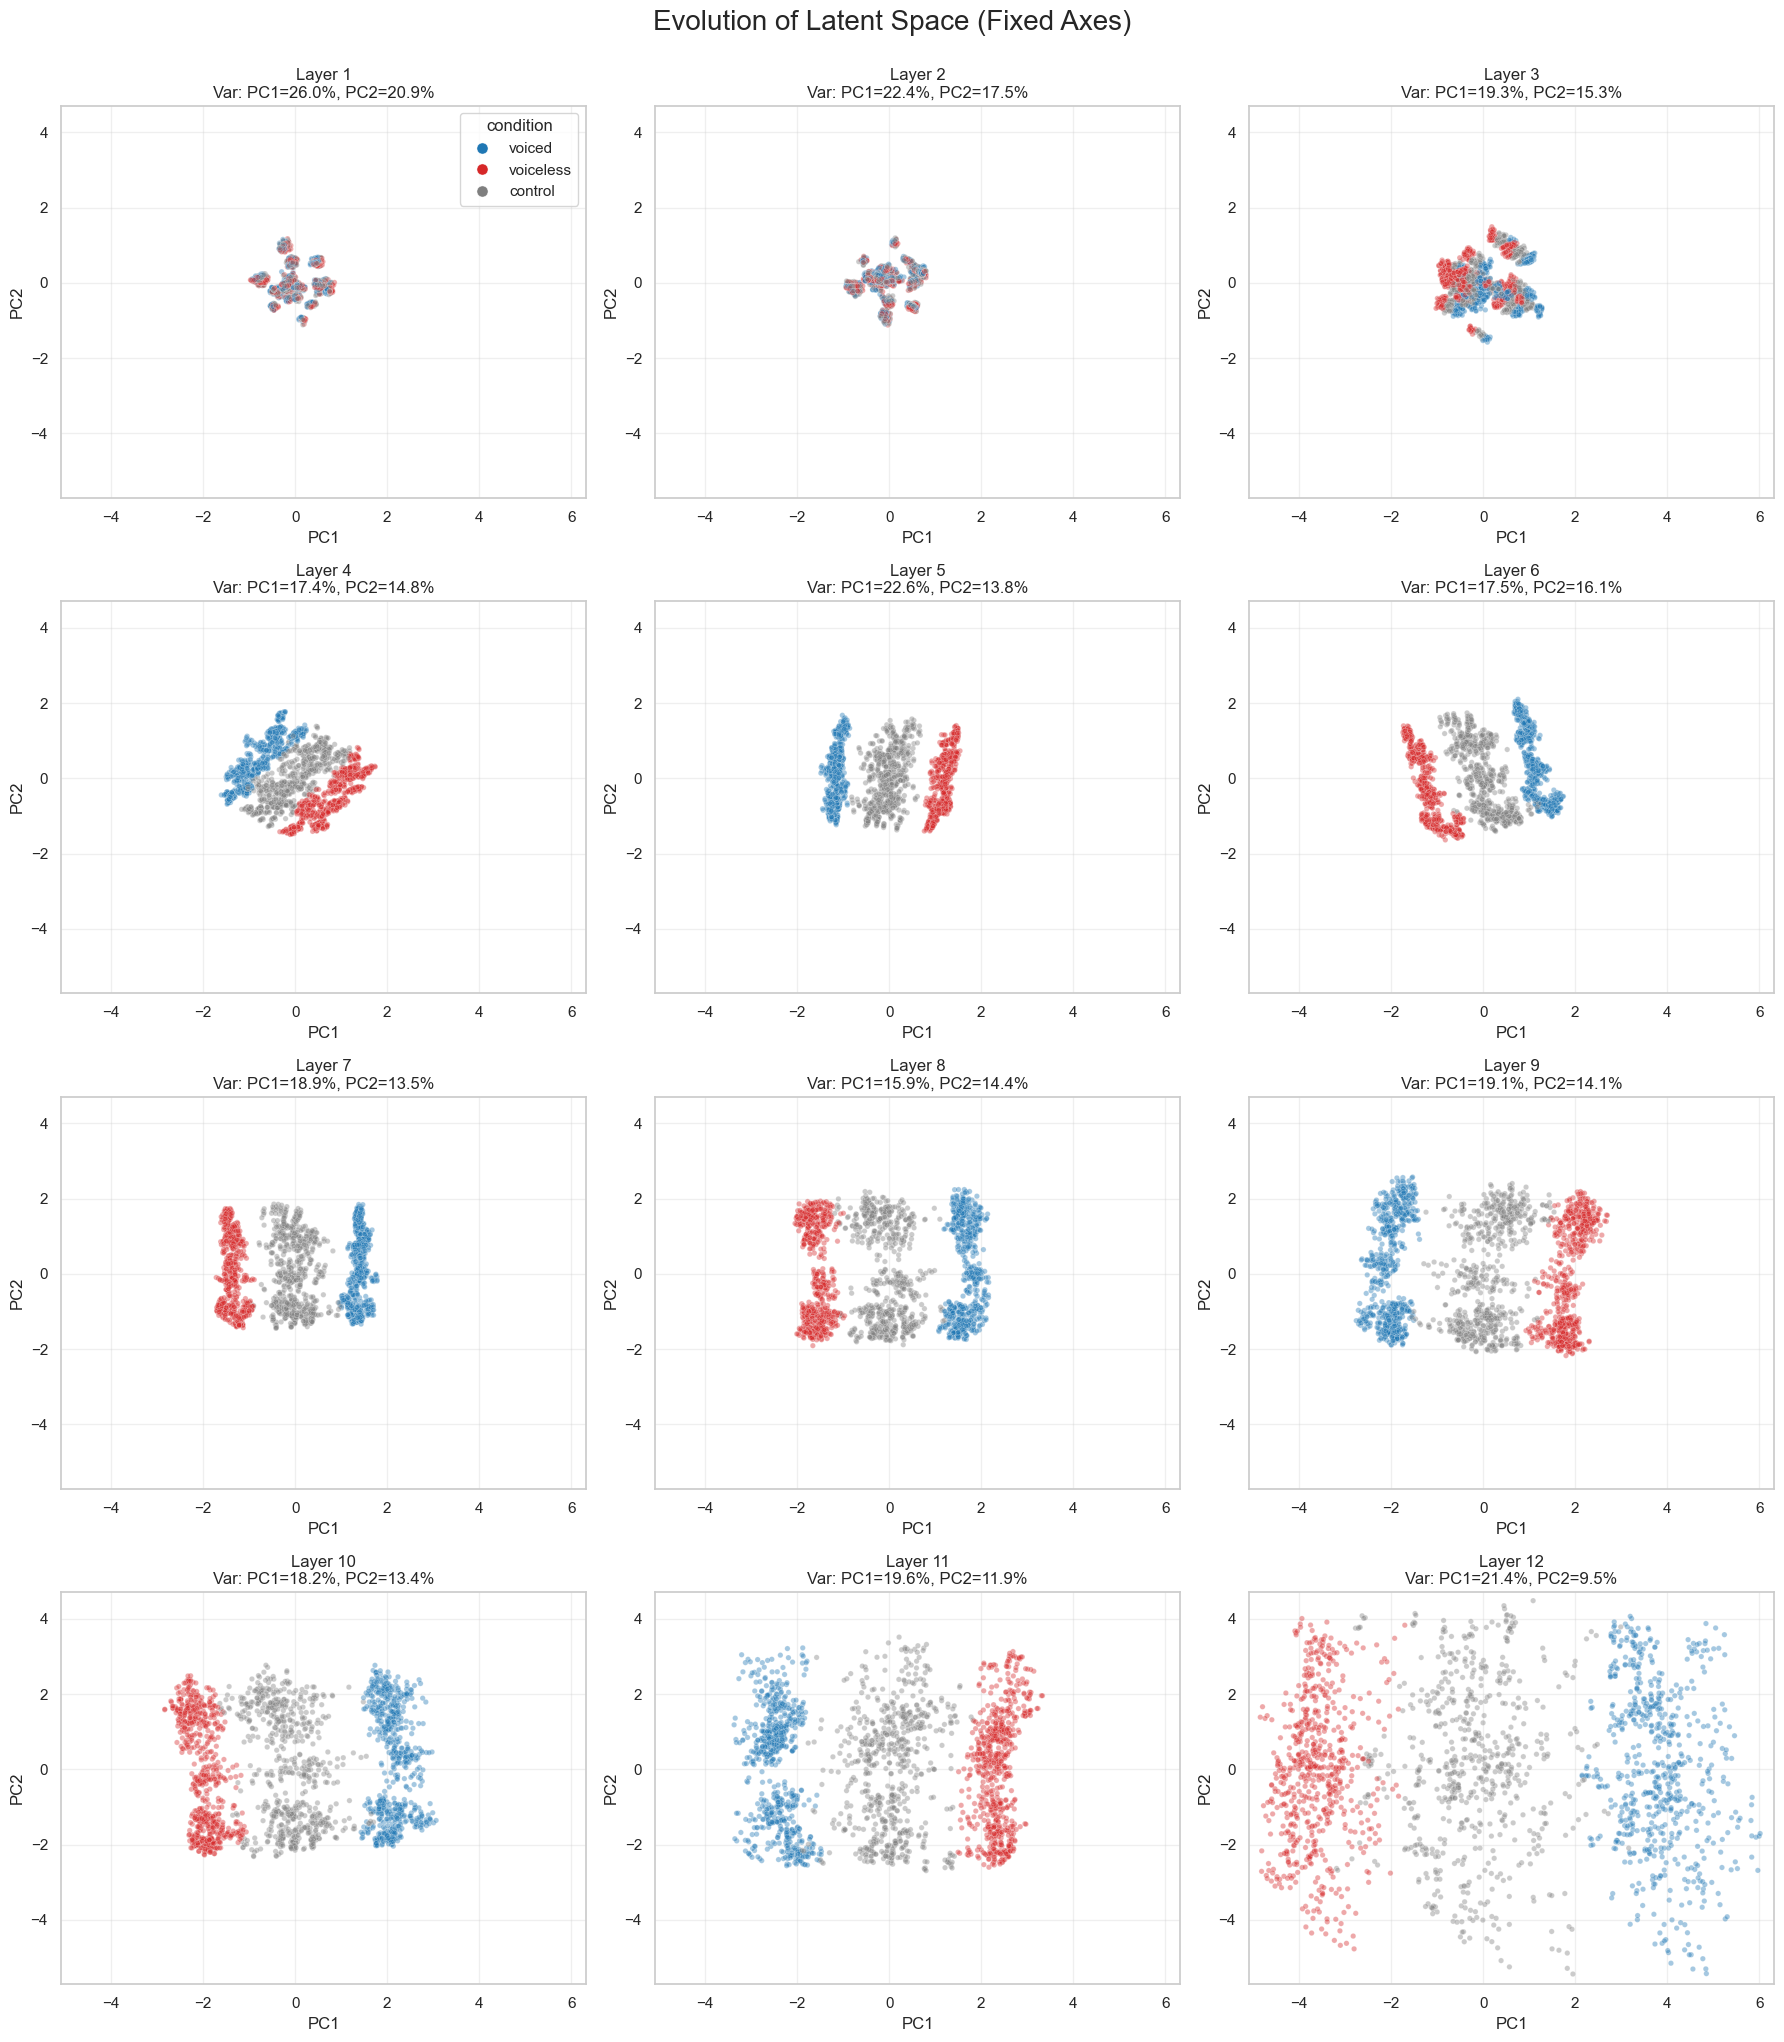

In [ ]:
def plot_layer_pca_grid(df):
    # global limits
    all_x = []
    all_y = []
    
    for i in range(1,13):
        X_temp = np.stack(df[f'layer_{i}'].values)
        pca_temp = PCA(n_components=2)
        X_pca_temp = pca_temp.fit_transform(X_temp)
        all_x.extend(X_pca_temp[:, 0])
        all_y.extend(X_pca_temp[:, 1])
    
    # Define limits with a 5% buffer
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_lims = (x_min - abs(x_min*0.05), x_max + abs(x_max*0.05))
    y_lims = (y_min - abs(y_min*0.05), y_max + abs(y_max*0.05))

    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()
    palette = {'voiced': '#1f77b4', 'voiceless': '#d62728', 'control': '#7f7f7f'}
    
    for i in range(1,13):
        ax = axes[i-1]
        layer_col = f'layer_{i}'
        X = np.stack(df[layer_col].values)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        sns.scatterplot(
            x=X_pca[:, 0], 
            y=X_pca[:, 1], 
            hue=df['condition'], 
            palette=palette,
            ax=ax,
            alpha=0.4,
            s=15,
            legend=(i == 1)
        )
        
        # for legend opacity
        if i == 1:
            leg = ax.get_legend()
            if leg:
                for lh in leg.legend_handles: 
                    lh.set_alpha(1) 
                    if hasattr(lh, 'set_sizes'):
                        lh.set_sizes([50])
                    elif hasattr(lh, 'set_markersize'):
                        lh.set_markersize(8)
        
        ax.set_xlim(x_lims)
        ax.set_ylim(y_lims)
        
        var_exp = pca.explained_variance_ratio_
        ax.set_title(f"Layer {i}\nVar: PC1={var_exp[0]:.1%}, PC2={var_exp[1]:.1%}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.3) 

    plt.tight_layout()
    plt.suptitle("Evolution of Latent Space (Fixed Axes)", fontsize=20, y=1.02)
    plt.show()

plot_layer_pca_grid(hidden_states)

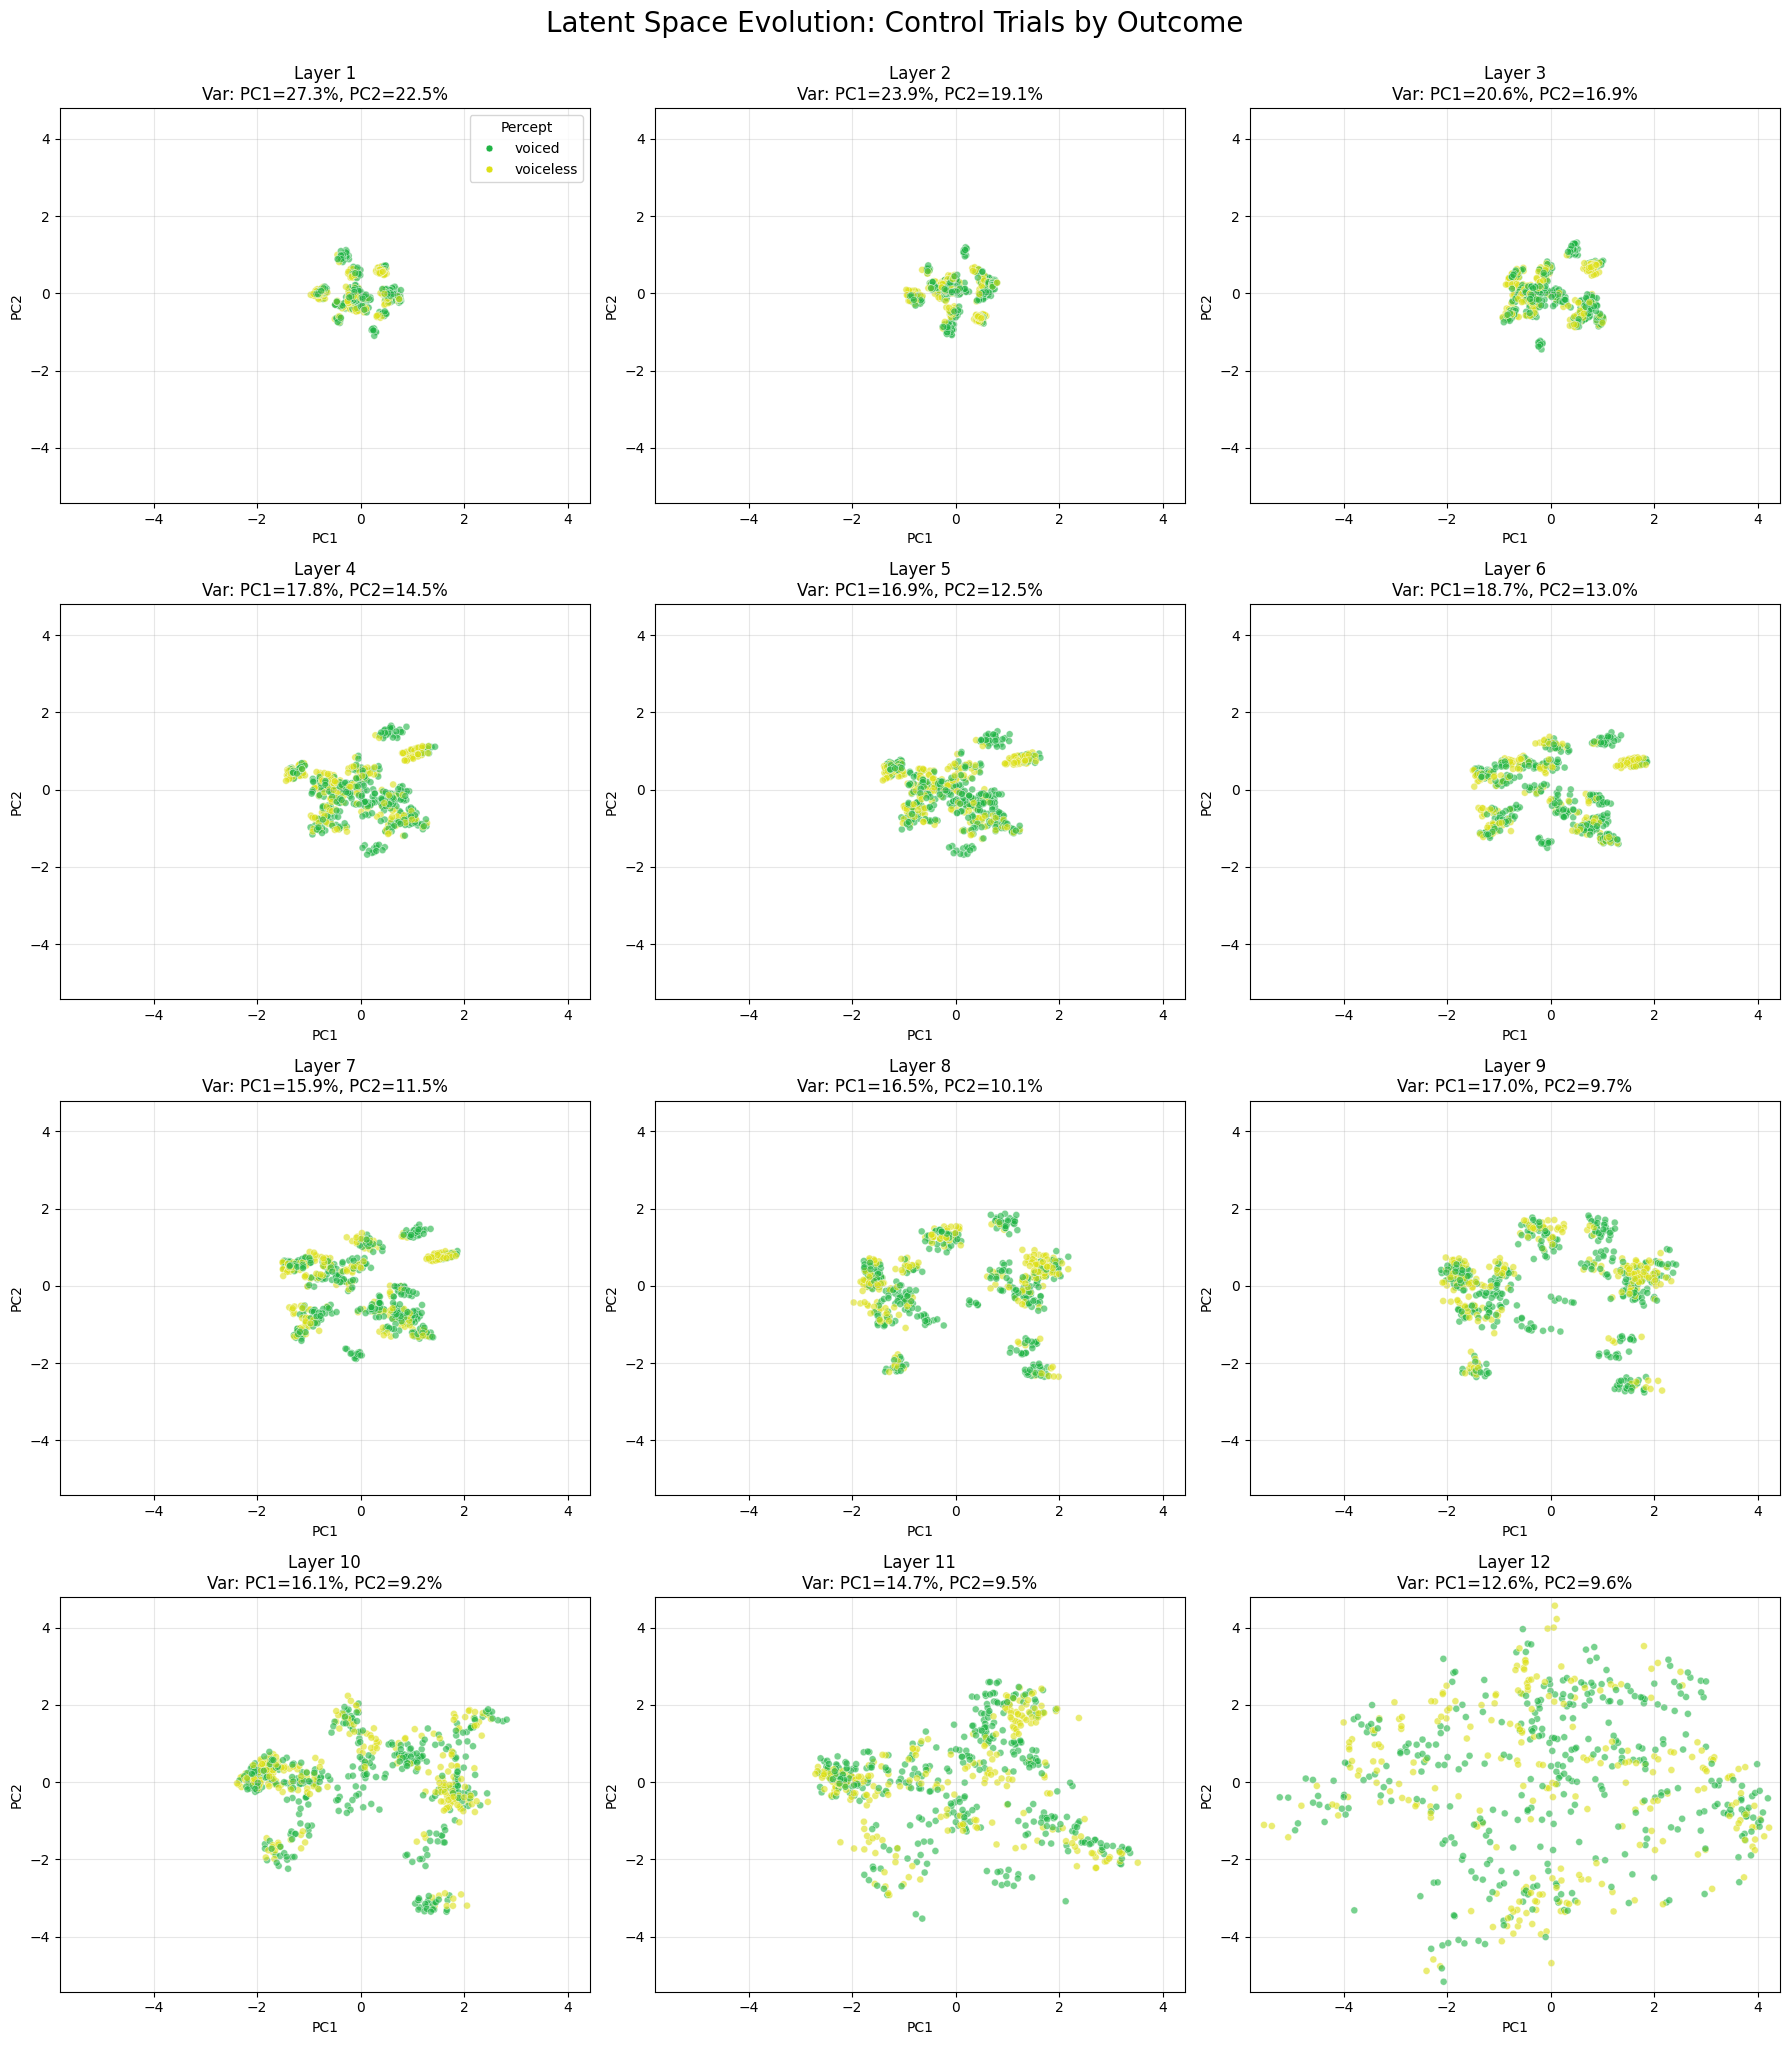

In [ ]:
def plot_control_outcome_pca_grid(df):
    # filter for only control trials
    control_df = df[df['condition'] == 'control'].copy()
    
    all_x = []
    all_y = []
    
    # run PCA for all layers to find the global min/max for the control subset
    for i in range(1, 13):
        X_temp = np.stack(control_df[f'layer_{i}'].values)
        pca_temp = PCA(n_components=2)
        X_pca_temp = pca_temp.fit_transform(X_temp)
        all_x.extend(X_pca_temp[:, 0])
        all_y.extend(X_pca_temp[:, 1])
    
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_lims = (x_min - abs(x_min*0.05), x_max + abs(x_max*0.05))
    y_lims = (y_min - abs(y_min*0.05), y_max + abs(y_max*0.05))

    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()
    
    palette = {'voiced': "#1fb444", 'voiceless': "#dde016"}
    
    for i in range(1, 13):
        ax = axes[i-1]
        layer_col = f'layer_{i}'
        
        X = np.stack(control_df[layer_col].values)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        sns.scatterplot(
            x=X_pca[:, 0], 
            y=X_pca[:, 1], 
            hue=control_df['transcript'], 
            palette=palette,
            ax=ax,
            alpha=0.6, 
            s=25, 
            legend=(i == 1) 
        )
        # for legend opacity
        if i == 1:
            leg = ax.get_legend()
            if leg:
                leg.set_title("Percept")
                for lh in leg.legend_handles: 
                    lh.set_alpha(1)
                    if hasattr(lh, 'set_sizes'):
                        lh.set_sizes([60])
        
        ax.set_xlim(x_lims)
        ax.set_ylim(y_lims)
        
        var_exp = pca.explained_variance_ratio_
        ax.set_title(f"Layer {i}\nVar: PC1={var_exp[0]:.1%}, PC2={var_exp[1]:.1%}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("Latent Space Evolution: Control Trials by Outcome", fontsize=20, y=1.02)
    plt.show()

# Run the new function
plot_control_outcome_pca_grid(hidden_states)

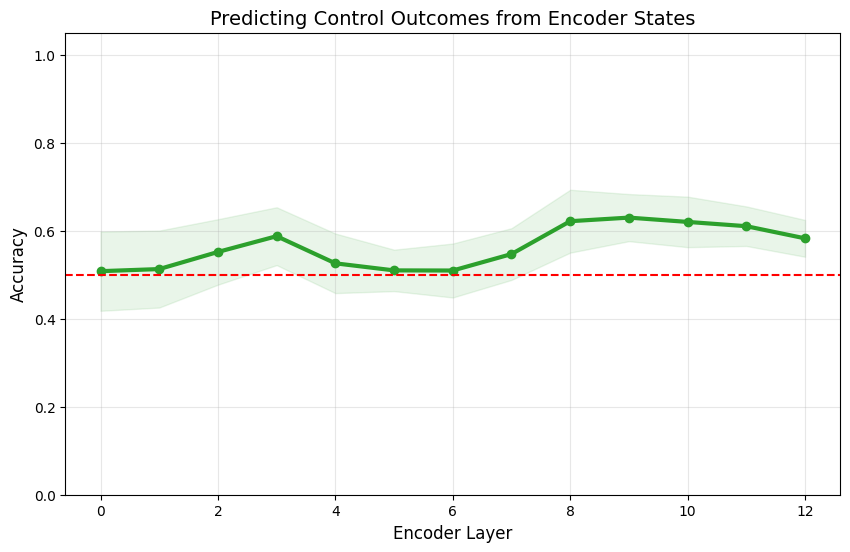

In [ ]:

with open('data/critical_hidden_states.pkl', 'rb') as file:
    hidden_states = pickle.load(file)

hidden_states = hidden_states[hidden_states['transcript'] != 'neither']

def run_linear_probes(df, condition_filter='control'):
    if condition_filter=='control':
        probe_df = df[df['condition'] == 'control'].copy()
    else:
        probe_df = df[df['condition'] != 'control'].copy()
    target_map = {'voiced': 0, 'voiceless': 1}
    y = probe_df['transcript'].map(target_map).values
    means = []
    sems = [] 
    
    for i in range(13):
        layer_col = f'layer_{i}'
        X = np.stack(probe_df[layer_col].values)
        X_scaled = StandardScaler().fit_transform(X)
        probe = LogisticRegression(max_iter=1000, C=0.1)
        scores = cross_val_score(probe, X_scaled, y, cv=5)        
        means.append(np.mean(scores))
        sems.append(np.std(scores) / np.sqrt(len(scores)))
        
    return np.array(means), np.array(sems)

means, errors = run_linear_probes(hidden_states)

plt.figure(figsize=(10, 6))

layers = range(13)
plt.fill_between(layers, means - (1.96 * errors), means + (1.96 * errors), color='#2ca02c', alpha=0.1)
plt.plot(layers, means, marker='o', linewidth=3, color='#2ca02c')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Predicting Control Outcomes from Encoder States", fontsize=14)
plt.xlabel("Encoder Layer", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.0, 1.05) 
plt.grid(True, alpha=0.3)
plt.show()

# All data

In [ ]:

with open('data/all_hidden_states.pkl', 'rb') as file:
    all_hidden_states = pickle.load(file)

all_hidden_states = all_hidden_states[all_hidden_states['transcript'] != 'neither']

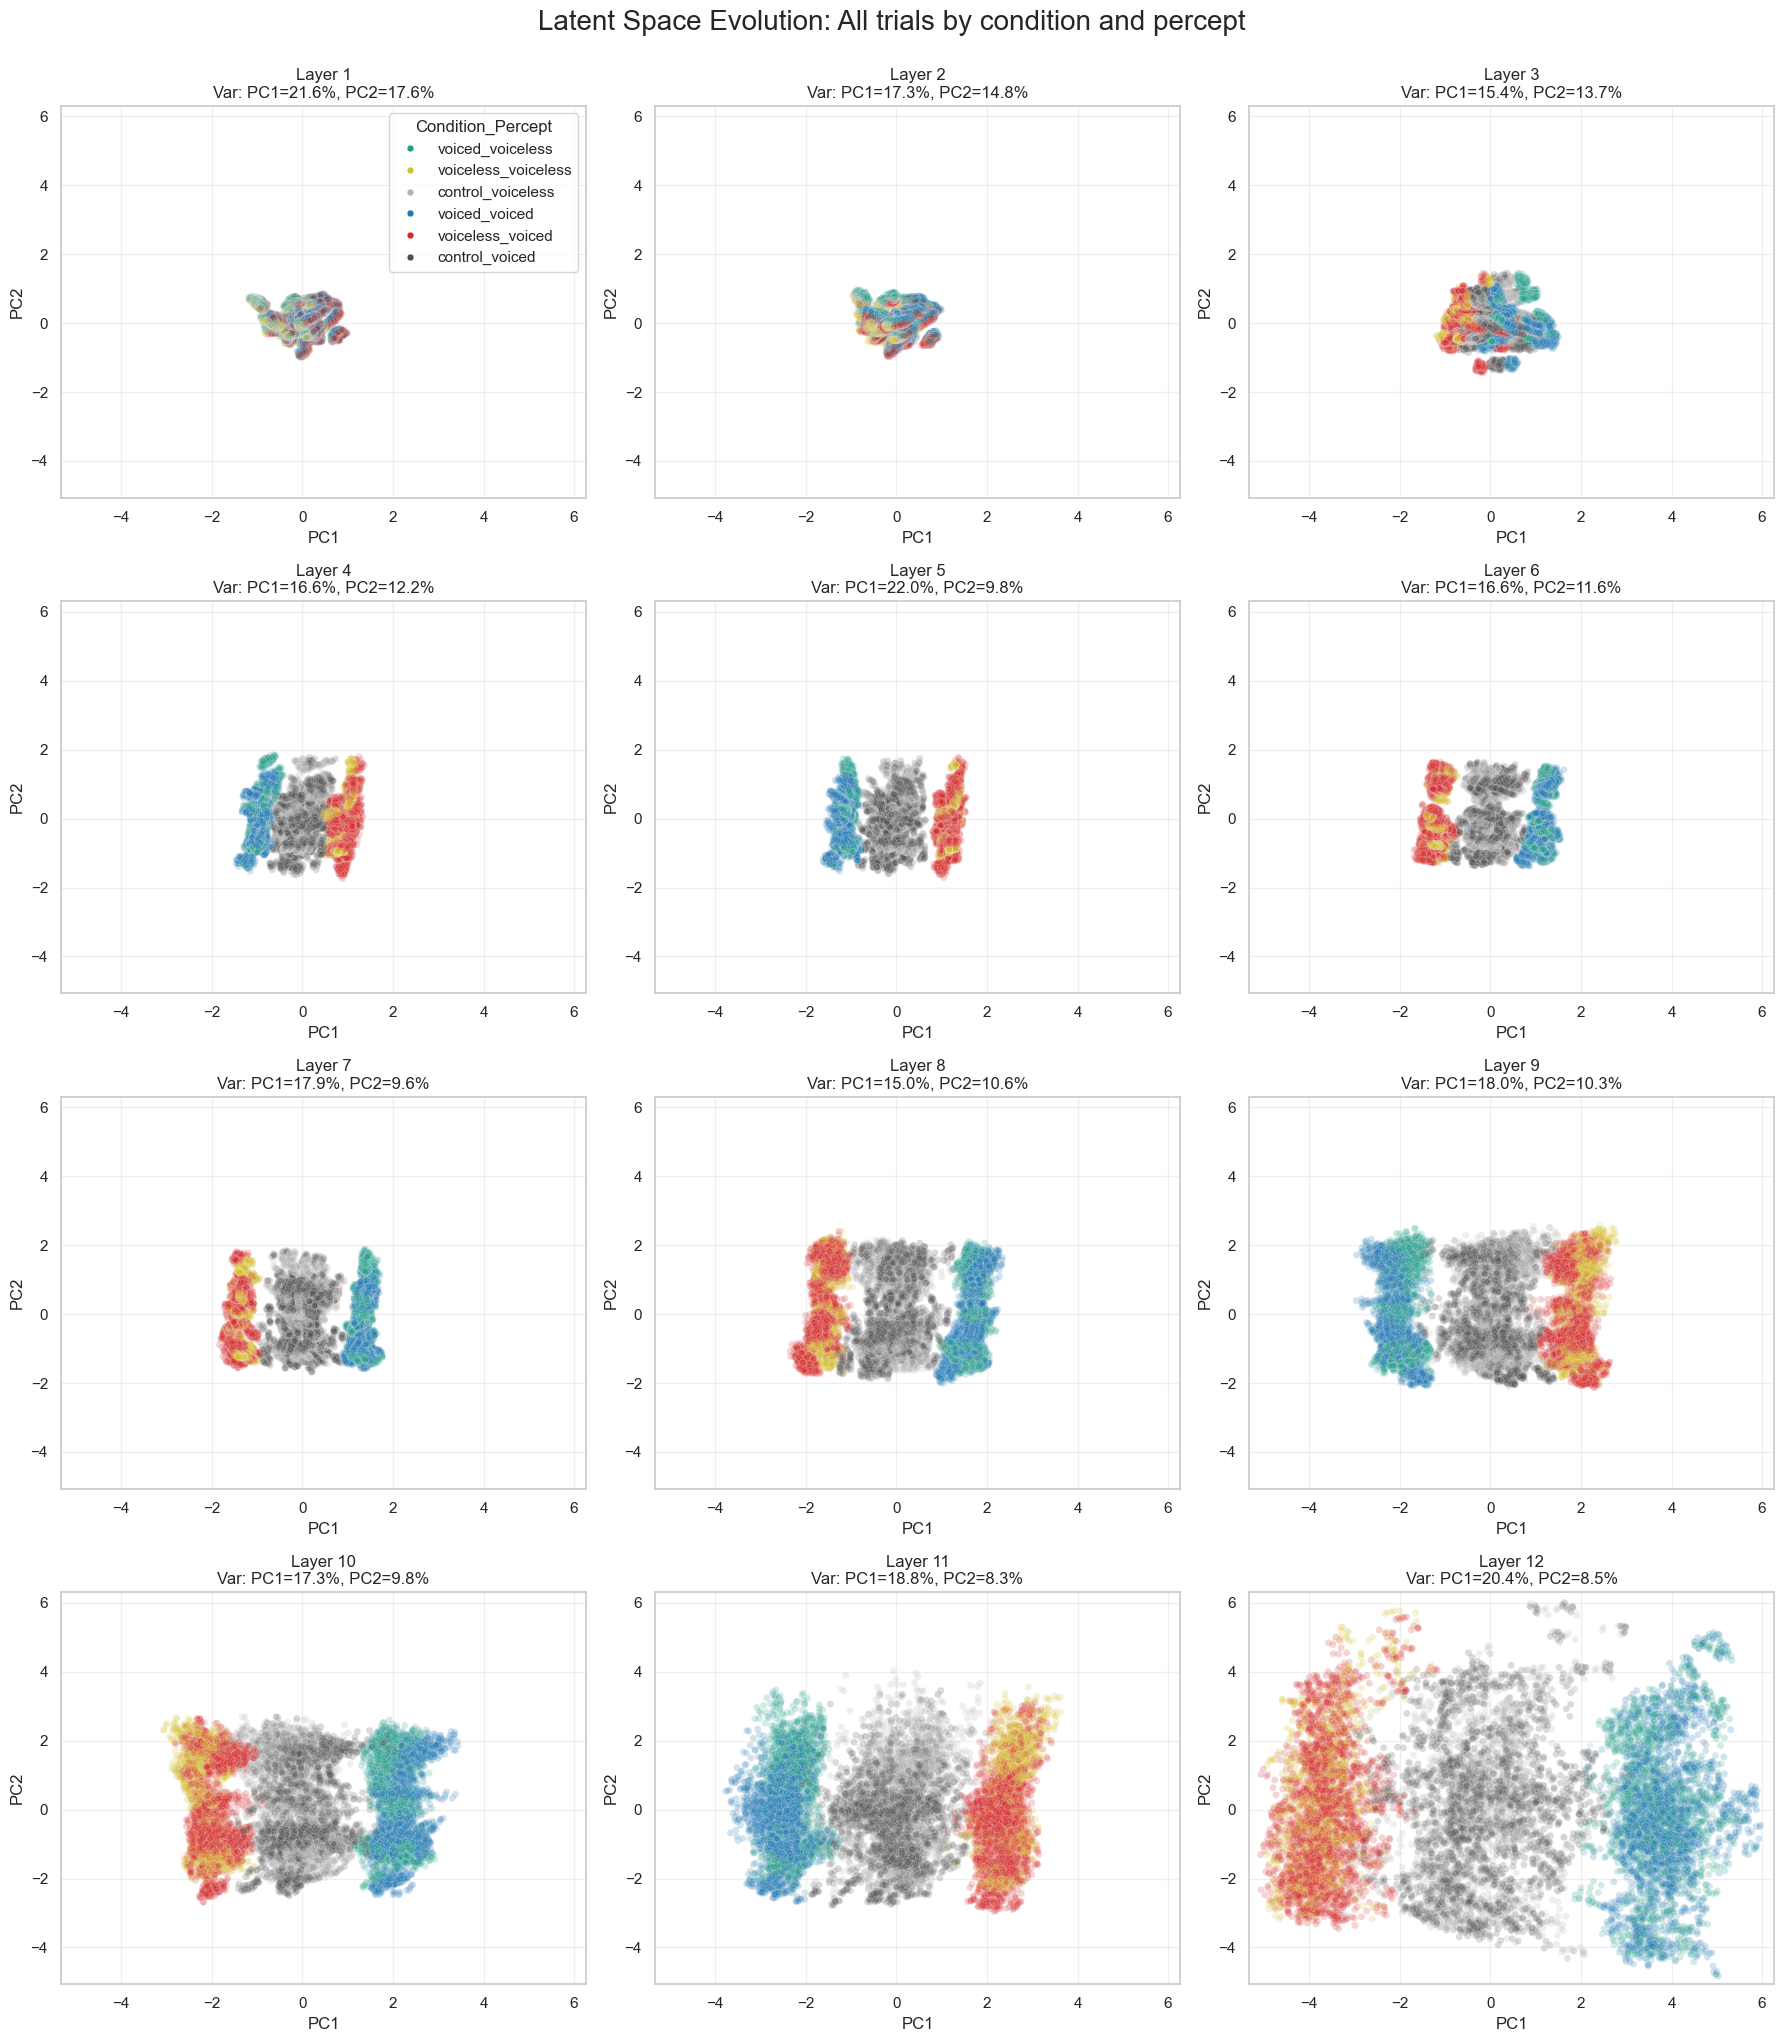

In [ ]:
def plot_all_data_pca_grid(df):
    # Create join condition/percept variable
    df_pca = df[df['transcript'] != 'neither'].copy()
    df_pca['condition_outcome'] = df_pca['condition'] + '_' + df_pca['transcript']
    
    all_x = []
    all_y = []
    
    for i in range(1, 13):
        X_temp = np.stack(df_pca[f'layer_{i}'].values)
        pca_temp = PCA(n_components=2)
        X_pca_temp = pca_temp.fit_transform(X_temp)
        all_x.extend(X_pca_temp[:, 0])
        all_y.extend(X_pca_temp[:, 1])
    
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_lims = (x_min - abs(x_min*0.05), x_max + abs(x_max*0.05))
    y_lims = (y_min - abs(y_min*0.05), y_max + abs(y_max*0.05))

    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()
    
    # Define colors for the perceptual outcomes

    palette = {'voiced_voiced': "#1f77b4", 'voiceless_voiced': "#d62728", 'control_voiced': "#504F4F",
               'voiced_voiceless': "#239d8b", 'voiceless_voiceless': "#d6bf27", 'control_voiceless': "#b4b1b1"}
    
    for i in range(1, 13):
        ax = axes[i-1]
        layer_col = f'layer_{i}'
        
        X = np.stack(df_pca[layer_col].values)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        sns.scatterplot(
            x=X_pca[:, 0], 
            y=X_pca[:, 1], 
            hue=df_pca['condition_outcome'], 
            palette=palette,
            ax=ax,
            alpha=0.2, 
            s=25, 
            legend=(i == 1) 
        )
        
        # For legend opacity
        if i == 1:
            leg = ax.get_legend()
            if leg:
                leg.set_title("Condition_Percept")
                for lh in leg.legend_handles: 
                    lh.set_alpha(1)
                    if hasattr(lh, 'set_sizes'):
                        lh.set_sizes([60])
        
        ax.set_xlim(x_lims)
        ax.set_ylim(y_lims)
        
        var_exp = pca.explained_variance_ratio_
        ax.set_title(f"Layer {i}\nVar: PC1={var_exp[0]:.1%}, PC2={var_exp[1]:.1%}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("Latent Space Evolution: All trials by condition and percept", fontsize=20, y=1.02)
    plt.show()

# Run the new function
plot_all_data_pca_grid(all_hidden_states)

In [ ]:
def run_probes_by_condition(df):
    conditions = df['condition'].unique()
    results = {}
    target_map = {'voiced': 0, 'voiceless': 1}
    
    for cond in conditions:
        print(f"Probing condition: {cond}")
        cond_df = df[df['condition'] == cond].copy()
        y = cond_df['transcript'].map(target_map).values
            
        means = []
        sems = []
        
        for i in range(13):
            X = np.stack(cond_df[f'layer_{i}'].values)
            X_scaled = StandardScaler().fit_transform(X)
            
            probe = LogisticRegression(max_iter=1000, C=0.1)
            # 5-fold CV to get the error bars
            scores = cross_val_score(probe, X_scaled, y, cv=5)
            
            means.append(np.mean(scores))
            sems.append(np.std(scores) / np.sqrt(len(scores)))
            
        results[cond] = {'means': np.array(means), 'sems': np.array(sems)}
        
    return results

results_by_cond = run_probes_by_condition(all_hidden_states)

Probing condition: voiced
Probing condition: voiceless
Probing condition: control


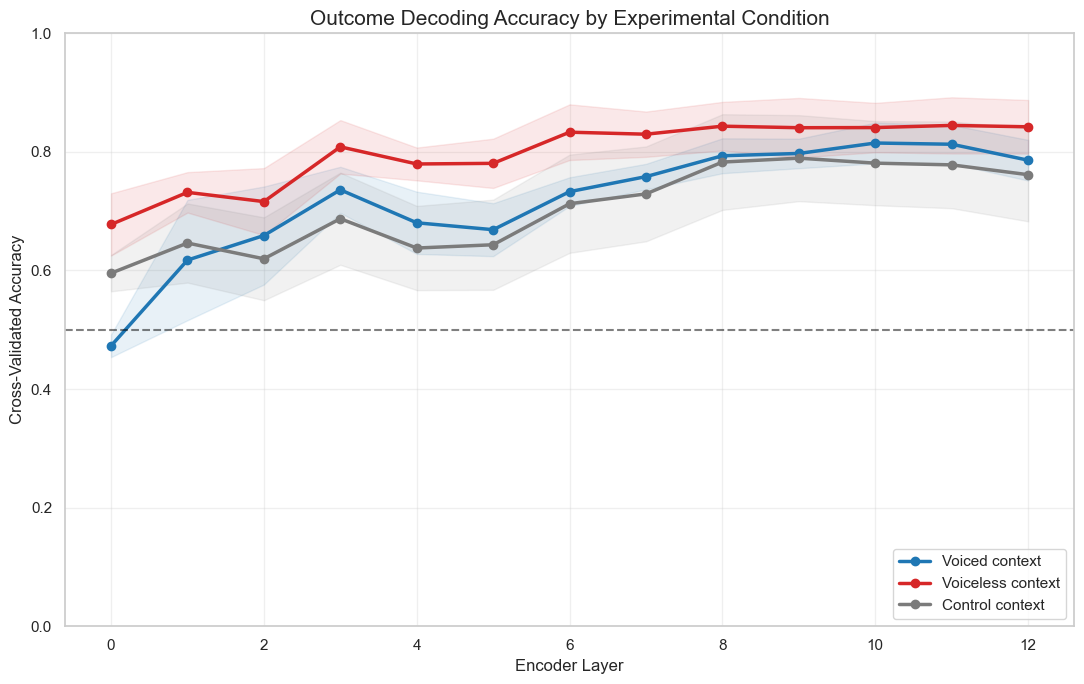

In [57]:
plt.figure(figsize=(11, 7))
layers = range(13)
palette = {'voiced': '#1f77b4', 'voiceless': '#d62728', 'control': "#7B7B7B"}

for cond, data in results_by_cond.items():
    m = data['means']
    s = data['sems']
    color = palette.get(cond, 'gray')
    
    # Plot Confidence Interval
    plt.fill_between(layers, m - (1.96 * s), m + (1.96 * s), color=color, alpha=0.1)
    
    # Plot Mean Accuracy
    plt.plot(layers, m, marker='o', label=f'{cond.title()} context', color=color, linewidth=2.5)

plt.axhline(0.5, color='black', linestyle='--', alpha=0.5)

plt.title("Outcome Decoding Accuracy by Experimental Condition", fontsize=15)
plt.xlabel("Encoder Layer", fontsize=12)
plt.ylabel("Cross-Validated Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()